In [150]:
import pandas as pd
import numpy as np
from functions import fun as f
from itertools import chain
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import des données

In [151]:
df_all_data = pd.read_csv("data/ATP.csv")

In [152]:
df_all_data.shape

(169690, 49)

#### On se considère comme un parieur sportif ou un bookmaker<br>
Par conséquent, je considère que les informations connues avant le début d'un match<br>
Je vais utiliser seulement, les variables ci-dessoous

In [153]:
# list(df_all_data)

In [154]:
liste_of_feat_used = ['tourney_id', 'tourney_name','surface','draw_size','tourney_level','tourney_date', 'match_num','best_of','round',
'loser_id','loser_seed','loser_entry','loser_name','loser_hand','loser_ht','loser_ioc','loser_age','loser_rank','loser_rank_points',
'winner_id', 'winner_seed','winner_entry','winner_name','winner_hand','winner_ht','winner_ioc','winner_age','winner_rank','winner_rank_points']  

In [155]:
# liste_features_to_keep = []
# liste_features_with_missing = []
for each_col in liste_of_feat_used:
    # On regarde quelles variables ont moins de 5% de valeurs manquantes
    pct_nan_values = (len(df_all_data[df_all_data[each_col].isnull()])/len(df_all_data)*100)  
    print ("feature", each_col,": ", pct_nan_values)

feature tourney_id :  0.0
feature tourney_name :  0.0
feature surface :  1.4962578820201544
feature draw_size :  99.27397018091814
feature tourney_level :  0.0
feature tourney_date :  0.0
feature match_num :  0.0
feature best_of :  0.0
feature round :  0.0
feature loser_id :  0.0
feature loser_seed :  80.63940126112323
feature loser_entry :  85.06747598562083
feature loser_name :  0.0
feature loser_hand :  0.05009134303730332
feature loser_ht :  18.05527727031646
feature loser_ioc :  0.0
feature loser_age :  2.9406564912487476
feature loser_rank :  14.014379162001298
feature loser_rank_points :  45.17944487005716
feature winner_id :  0.0
feature winner_seed :  61.521008898579765
feature winner_entry :  91.30885732806883
feature winner_name :  0.0
feature winner_hand :  0.022983086805350935
feature winner_ht :  11.082562319523838
feature winner_ioc :  0.0
feature winner_age :  1.0377747657493075
feature winner_rank :  11.737285638517296
feature winner_rank_points :  44.43337851376039


On voit qu'il y a beaucoup de valeurs manquantes, plaçons nous après 1991

In [156]:
df_all_data = df_all_data[liste_of_feat_used]

In [157]:
df_all_data['tourney_date_str'] = df_all_data['tourney_date'].map(str)
df_all_data['tourney_year_numeric'] = df_all_data['tourney_date_str'].map(lambda x: int(x[0:4]))

In [158]:
df_all_data_after_1991 = df_all_data[df_all_data['tourney_year_numeric'] >= 1991]

In [159]:
#df_all_data_after_1992 = df_all_data[df_all_data['tourney_year_numeric'] >= 1992]
#df_all_data_after_1992.shape

In [160]:
# On extrait les % de valeurs manquantes par colonne (NaN values)
for each_col in liste_of_feat_used:
    # On regarde quelles variables ont moins de 5% de valeurs manquantes
    pct_nan_values = (len(df_all_data_after_1991[df_all_data_after_1991[each_col].isnull()])/len(df_all_data)*100)  
    print ("feature", each_col,": ", pct_nan_values)

feature tourney_id :  0.0
feature tourney_name :  0.0
feature surface :  0.06953857033413872
feature draw_size :  54.703871766161825
feature tourney_level :  0.0
feature tourney_date :  0.0
feature match_num :  0.0
feature best_of :  0.0
feature round :  0.0
feature loser_id :  0.0
feature loser_seed :  42.70375390417821
feature loser_entry :  43.996110554540635
feature loser_name :  0.0
feature loser_hand :  0.025340326477694623
feature loser_ht :  5.147622134480524
feature loser_ioc :  0.0
feature loser_age :  0.11609405386292651
feature loser_rank :  1.3135718074135188
feature loser_rank_points :  1.8563262419706523
feature winner_id :  0.0
feature winner_seed :  32.61358948671106
feature winner_entry :  48.27744710943485
feature winner_name :  0.0
feature winner_hand :  0.010607578525546585
feature winner_ht :  3.094466379869173
feature winner_ioc :  0.0
feature winner_age :  0.051269962873475156
feature winner_rank :  0.6016854263657258
feature winner_rank_points :  1.149743650185

On enlève les variables ayant des % valeurs manquantes superieurs à 30%,<br>
commme : draw_size, loser_seed,loser_entry, winner_seed,winner_entry<br>
<br>
En effet, on va utiliser un modèle XGBoost qui sait gérer les valeurs manquantes<br>
tant que le taux de valeurs manquantes pour une variable donnée n'est pas trop élevé 

In [161]:
liste_of_feat_used = [each for each in liste_of_feat_used if each not in ['draw_size', 'loser_seed','loser_entry', 'winner_seed','winner_entry']]

In [162]:
liste_of_feat_used.append('tourney_year_numeric')

In [163]:
df_all_data_after_1991 = df_all_data_after_1991[liste_of_feat_used]

In [164]:
df_all_data_after_1991.shape

(92827, 25)

On a maintenant un dataset avec 92827 lignes et 24 variables

Je suis parti du principe que les statistiques des joueurs sont fiables

Principe du modèle de Machine Learning:<br>
étant donné un match entre un joueur 1 = Djokovic et un joueur 2 = Federer<br>
je pense qu'il est important de distinguer :
- la probabilité que le joueur 1, Djokovic gagne sachant que son adversaire est le joueur 2, Federer 
- la probabilité que le joueur 2, Federer gagne sachant que son adversaire est le joueur 1, Dojokovic 

En raison de ce principe, je crée un dataset avec les lignes dupliquées et en inversant l'ordre des joueurs en colonnes

In [165]:
# On se sert de "df_temp" pour créer le dataset de lignes dupliquées
df_temp = df_all_data_after_1991

Création des lignes dupliquées

In [166]:
liste_var_tourney = ['tourney_id','tourney_name','surface','tourney_level','tourney_date','match_num','best_of','round','tourney_year_numeric']

In [167]:
# list(df_temp)

In [168]:
liste_var_loser = [each for each in list(df_temp) if 'loser' in each]
liste_var_winner = [each for each in list(df_temp) if 'winner' in each]

In [169]:
df_temp_ordered = pd.concat([df_temp[liste_var_tourney], df_temp[liste_var_winner], df_temp[liste_var_loser]], axis = 1)

In [170]:
liste_player_opponent = [each.replace("loser","opponent") for each in list(df_temp_ordered)]
liste_player_opponent = [each.replace("winner","player") for each in liste_player_opponent]
df_temp_ordered.columns = liste_player_opponent

In [171]:
list(df_temp_ordered)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [172]:
df_temp_ordered['Y'] = 0

On crée d'abord la colonne des Y = 1 signifiant que le joueur de "droite" dans le dataframe est le vainqueur<br>
Ajout des Y pour les lignes non dupliquées

In [173]:
df_temp = pd.concat([df_temp[liste_var_tourney], df_temp[liste_var_loser], df_temp[liste_var_winner]], axis = 1)

In [174]:
# df_temp.shape

In [175]:
del liste_player_opponent
liste_player_opponent = [each.replace("loser","player") for each in list(df_temp)]
liste_player_opponent = [each.replace("winner","opponent") for each in liste_player_opponent]

In [176]:
# liste_player_opponent

In [177]:
df_temp.columns = liste_player_opponent

In [178]:
df_temp['Y'] = 1

Identifiants de matchs

In [179]:
df_temp['id_match'] = df_temp['tourney_id'].astype(str) + "_" + df_temp['match_num'].astype(str)

In [180]:
list(df_temp_ordered)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y']

In [181]:
df_temp_ordered['id_match'] = df_temp_ordered['tourney_id'].astype(str) + "_" + df_temp_ordered['match_num'].astype(str)

In [182]:
df_all_data_with_duplicates = pd.concat([df_temp,df_temp_ordered])

In [183]:
df_all_data_with_duplicates.shape

(185654, 27)

In [184]:
df_all_data_with_duplicates[["tourney_id","match_num","id_match"]].head()

,tourney_id,match_num,id_match
76863,1991-301,1,1991-301_1
76864,1991-301,2,1991-301_2
76865,1991-301,3,1991-301_3
76866,1991-301,4,1991-301_4
76867,1991-301,5,1991-301_5


On crée maintenant les features

Recodage de la variable 'round' de manière relative au type de tournoi:
on compte le nombre de tours de manière différente en fonction de si il s'agit
d'un tournoi du Grand Chelem, d'un Master 1000 ou bien d'un tournoi de type ATP Final (Masters de fin de saison)

In [185]:
list(df_all_data_with_duplicates)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'id_match']

In [186]:
#df_all_data_with_duplicates['round'].unique()
#df_all_data_with_duplicates.groupby(['tourney_level'])['round'].unique()

In [187]:
df_all_data_with_duplicates['round_ordinal'] = df_all_data_with_duplicates.apply(f.recode_round_to_ordinal, axis = 1)

In [188]:
del liste_of_feat_used
liste_of_feat_used = list(df_all_data_with_duplicates)
liste_var_numeric = list(df_all_data_with_duplicates.describe())
liste_var_non_numeric = [each for each in liste_of_feat_used if each not in liste_var_numeric]

On peut :
- on pourrait extraire le pays à partir du nom du tournoi mais ici, on ne le fait pas
- on a besoin de la variable surface = priorité
- on a besoin de la variable tourney_level = priorité
- on auarait besoin de loser_ioc et winner_ioc pour savoir si un joueur joue dans son pays ou pas

In [189]:
liste_var_non_numeric

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'round',
 'player_name',
 'player_hand',
 'player_ioc',
 'opponent_name',
 'opponent_hand',
 'opponent_ioc',
 'id_match']

In [190]:
# Création du pays du tournoi<br>
# Ensuite toutes les variables pourront être transformées avec "labels encoding" de Scikit-learn

In [191]:
# Pays du tournoi

In [192]:
# df_all_data_with_duplicates['tourney_name'].value_counts()

Application de "labels encoding" aux variables : surface et tourney_level

In [193]:
df_all_data_with_duplicates['surface'] = df_all_data_with_duplicates['surface'].astype(str)
df_all_data_with_duplicates['player_hand'] = df_all_data_with_duplicates['player_hand'].astype(str)
df_all_data_with_duplicates['opponent_hand'] = df_all_data_with_duplicates['opponent_hand'].astype(str)

In [194]:
for each in ['surface','tourney_level','player_hand','opponent_hand']:
    #print (each)
    df_all_data_with_duplicates = f.to_le(df_all_data_with_duplicates,each)

In [195]:
df_all_data_with_duplicates.head()

,tourney_id,tourney_name,surface,tourney_level,tourney_date,match_num,best_of,round,tourney_year_numeric,player_id,...,opponent_age,opponent_rank,opponent_rank_points,Y,id_match,round_ordinal,surface_labels_encoding,tourney_level_labels_encoding,player_hand_labels_encoding,opponent_hand_labels_encoding
76863,1991-301,Auckland,Hard,A,19910107,1,3,R32,1991,101746,...,25.61,9.0,1487.0,1,1991-301_1,4,3,0,1,1
76864,1991-301,Auckland,Hard,A,19910107,2,3,R32,1991,100587,...,21.55,94.0,371.0,1,1991-301_2,4,3,0,1,1
76865,1991-301,Auckland,Hard,A,19910107,3,3,R32,1991,101601,...,25.32,77.0,468.0,1,1991-301_3,4,3,0,1,1
76866,1991-301,Auckland,Hard,A,19910107,4,3,R32,1991,101332,...,25.83,65.0,502.0,1,1991-301_4,4,3,0,0,1
76867,1991-301,Auckland,Hard,A,19910107,5,3,R32,1991,101735,...,19.71,190.0,142.0,1,1991-301_5,4,3,0,1,1


On s'occupe maintenant de la création des features numériques

In [196]:
liste_var_numeric

['tourney_date',
 'match_num',
 'best_of',
 'tourney_year_numeric',
 'player_id',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'round_ordinal']

On va utiliser en priorité les variables : "player_" et "opponent_" comme features numériques

In [197]:
liste_var_player = [each for each in liste_var_numeric if 'player' in each and each != 'player_id']
liste_var_opponent = [each for each in liste_var_numeric if 'opponent' in each and each != 'opponent_id']

In [198]:
# liste_feat_le_for_xgboost = [each for each in list(df_all_data_with_duplicates) if 'labels_encoding' in each or 'ordinal' in each]
liste_feat_le_for_xgboost = [each for each in list(df_all_data_with_duplicates) if 'labels_encoding' in each]

In [199]:
liste_feat_le_for_xgboost

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding']

In [200]:
init = []
init.append(liste_feat_le_for_xgboost)
init.append(liste_var_player)
init.append(liste_var_opponent)

liste_feat_for_xgboost_modele_1 = list(chain(*init))

In [201]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

#### On réalise Holdout : on va créer 
- un train set =  60 % 
- validation set = , 20 % 
- test set = 20 %

In [202]:
df_all_data_with_duplicates[['id_match','player_name','opponent_name']].sort_values(by=['id_match']).head()

,id_match,player_name,opponent_name
77131,1991-201_1,Rodolphe Gilbert,Luiz Mattar
77131,1991-201_1,Luiz Mattar,Rodolphe Gilbert
77140,1991-201_10,Henrik Holm,Gianluca Pozzi
77140,1991-201_10,Gianluca Pozzi,Henrik Holm
77141,1991-201_11,Lawson Duncan,Martin Wostenholme


In [203]:
id_match_unique = df_all_data_with_duplicates['id_match'].unique()

In [204]:
# Shuffle du numpy array
np.random.shuffle(id_match_unique)

In [205]:
# 60%, 20% et 20%
idx_1 = int(0.6*len(id_match_unique))
idx_2 = int(0.8*len(id_match_unique))
id_train = id_match_unique[:idx_1]
id_valid = id_match_unique[idx_1+1:idx_2]
id_test = id_match_unique[idx_2+1:]

In [206]:
df_all_data_with_duplicates.shape

(185654, 32)

In [207]:
X_train_all_columns = df_all_data_with_duplicates[df_all_data_with_duplicates['id_match'].isin(id_train)]
Y_train = df_all_data_with_duplicates[["id_match","Y"]][df_all_data_with_duplicates[["id_match","Y"]]['id_match'].isin(id_train)][["Y"]]

In [208]:
X_train_all_columns[['id_match']].head()

,id_match
76864,1991-301_2
76873,1991-301_11
76874,1991-301_12
76875,1991-301_13
76877,1991-301_15


In [209]:
X_train_all_columns.shape

(111392, 32)

In [210]:
Y_train.sample(n=10)

,Y
103581,0
154847,0
78246,1
82874,1
92428,1
98316,0
109302,0
99569,1
141720,0
104623,0


In [211]:
# (X_train_all_columns.shape[0]/df_all_data_with_duplicates.shape[0])*100

In [212]:
X_valid_all_columns = df_all_data_with_duplicates[df_all_data_with_duplicates['id_match'].isin(id_valid)]
Y_valid = df_all_data_with_duplicates[["id_match","Y"]][df_all_data_with_duplicates[["id_match","Y"]]['id_match'].isin(id_valid)][["Y"]]
X_test_all_columns =  df_all_data_with_duplicates[df_all_data_with_duplicates['id_match'].isin(id_test)]
Y_test = df_all_data_with_duplicates[["id_match","Y"]][df_all_data_with_duplicates[["id_match","Y"]]['id_match'].isin(id_test)]

In [213]:
# (X_valid_all_columns.shape[0]/df_all_data_with_duplicates.shape[0])*100

In [215]:
X_train = X_train_all_columns[liste_feat_for_xgboost_modele_1]
X_valid = X_valid_all_columns[liste_feat_for_xgboost_modele_1]

On crée un XGBoost accompagné d'un tuning des hyperparamètres

In [216]:
X_train.shape

(111392, 12)

In [217]:
X_train.head()

,surface_labels_encoding,tourney_level_labels_encoding,player_hand_labels_encoding,opponent_hand_labels_encoding,player_ht,player_age,player_rank,player_rank_points,opponent_ht,opponent_age,opponent_rank,opponent_rank_points
76864,3,0,1,1,188.0,31.82,220.0,114.0,180.0,21.55,94.0,371.0
76873,3,0,1,0,183.0,23.07,67.0,497.0,185.0,25.14,93.0,376.0
76874,3,0,1,1,188.0,25.75,87.0,418.0,190.0,25.77,35.0,759.0
76875,3,0,1,1,185.0,24.45,92.0,388.0,188.0,24.91,63.0,518.0
76877,3,0,1,1,183.0,24.10,90.0,401.0,173.0,25.79,83.0,432.0


In [218]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

In [219]:
Y_train.shape

(111392, 1)

In [220]:
%%time
# n_iter = 100
n_iter = 2
df_result_models = pd.DataFrame(columns = ['colsample_bytree','learning_rate','max_depth','n_estimators','subsample','min_child_weight','reg_lambda','AUC_train','AUC_valid'])

for each in range(1,n_iter):
    
    colsample_bytree_value = np.random.uniform(0.3,0.7)
    learning_rate_value = np.random.uniform(0.03, 0.3)
    max_depth_value = np.random.randint(7,20)
    # max_depth_value = np.random.randint(5,12)
    n_estimators_value = np.random.randint(400, 500)
    # n_estimators_value = np.random.randint(100, 200)
    # subsample_value = np.random.uniform(0.4, 0.6)
    subsample_value = 1
    reg_lambda_value = np.random.uniform(5, 20)
    min_child_weight_value = np.random.randint(0,300)
    
    xgb_model = xgb.XGBClassifier(
        colsample_bytree = colsample_bytree_value,
        learning_rate = learning_rate_value,
        max_depth = max_depth_value,
        n_estimators = n_estimators_value,
        subsample = subsample_value,
        reg_lambda = reg_lambda_value,
        n_jobs = 2,
        min_child_weight = min_child_weight_value,
        objective='binary:logistic')
        
    result = xgb_model.fit(X_train, Y_train.values.ravel())
    predicted_values = xgb_model.predict_proba(X_train)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
    
    AUC_train_value = roc_auc_score(Y_train.values, predicted_values)
    
    predicted_values = xgb_model.predict_proba(X_valid)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    AUC_valid_value = roc_auc_score(Y_valid.values, predicted_values)
    
    if AUC_train_value != None and AUC_valid_value != None:
    
        df_result_models = df_result_models.append({'colsample_bytree': colsample_bytree_value, 
                                 'learning_rate':learning_rate_value,
                                 'max_depth':max_depth_value,
                                 'n_estimators':n_estimators_value,
                                 'subsample':subsample_value,
                                 'reg_lambda':reg_lambda_value,
                                 'min_child_weight':min_child_weight_value,                 
                                 'AUC_train':AUC_train_value,
                                 'AUC_valid':AUC_valid_value}, ignore_index= True)

KeyboardInterrupt: 

In [221]:
# stockage en .pkl
# joblib.dump(xgb_model, "xgboost_modele_1.pkl", compress=9)
# pour le reload
xgb_model = joblib.load("xgboost_modele_1.pkl")

In [222]:
#result = xgb_model.fit(X_train, Y_train.values.ravel())
predicted_values = xgb_model.predict_proba(X_train)[:,1]
predicted_values = np.expand_dims(predicted_values, axis=1)

In [223]:
predicted_values.shape

(111392, 1)

##### Avec subsample = 1 : je garde ce résultat

In [83]:
# df_result_models

In [513]:
# Avec subsample_value = np.random.uniform(0.4, 0.6)
df_result_models

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,min_child_weight,reg_lambda,AUC_train,AUC_valid
0,0.555485,0.161401,14.0,412.0,0.545317,217.0,11.247714,0.778831,0.718195


Avec 'round_ordinal' : 0.81 et 0.70<br>
Cela semble donner du sur-apprentissage:<br>
On pourrait faire varier successivement chaque hyperparamètre en gardant les autres hyperparamètres fixé

Importance des variables

In [66]:
dict_feature_importance = {}
for each in list(zip(list(X_train),xgb_model.feature_importances_)):
    dict_feature_importance[each[0]] = each[1]
sorted_importances = sorted(dict_feature_importance.items() , reverse = True, key=lambda x: x[1])
for elem in sorted_importances :
    print(elem[0] , " ::" , elem[1])

player_rank  :: 0.17257395
opponent_rank_points  :: 0.12709759
opponent_rank  :: 0.119993925
player_rank_points  :: 0.088540286
player_hand_labels_encoding  :: 0.085398465
tourney_level_labels_encoding  :: 0.08162489
opponent_hand_labels_encoding  :: 0.07802199
player_ht  :: 0.076015785
opponent_ht  :: 0.055617627
surface_labels_encoding  :: 0.03886766
player_age  :: 0.03855893
opponent_age  :: 0.03768892


On obtient comme prédiction sur le test set deux prédictions<br>
pour chaque match présent dans le test set sous la forme d'un "id_match"

Ces deux prédictions sont:
- la probabilité que le joueur n°1 gagne contre son adversaire le joueur n°2
- la probabilité que le joueur n°2 gagne contre son adversaire le joueur n°1

En considérant la différence des ces deux prédictions, on va pouvoir prédire quel joueur va gagner le match.

Ci-dessous, on calcule les deux prédictions pour un match donné dans le test set (3ème échantillon)

In [68]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

#### Hypothèse des gains en cas de bonne ou mauvaise prédiction:
- on gagne la valeur de la mise en cas de bonne prédiction
- on perd la valeur de la mise en cas de mauvaise prédiction

Code pour créer la fonction: <br>
- input : dataframe df_all_data_with_duplicates et numpy array : id_train ou id_valid ou id_test
- output: dataframe df_pred contenant pour chaque match la winning margin, les prédictions et les Y vérité

In [69]:
list(df_all_data_with_duplicates)

['tourney_id',
 'tourney_name',
 'surface',
 'tourney_level',
 'tourney_date',
 'match_num',
 'best_of',
 'round',
 'tourney_year_numeric',
 'player_id',
 'player_name',
 'player_hand',
 'player_ht',
 'player_ioc',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_id',
 'opponent_name',
 'opponent_hand',
 'opponent_ht',
 'opponent_ioc',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'Y',
 'id_match',
 'round_ordinal',
 'surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding']

In [71]:
def max_two(df):
    resultat = max(df['pred_1'], df['pred_2'])
    return resultat

A faire en cas de pb avec "liste_feat_for_xgboost_modele_1"

In [144]:
liste_feat_le_for_xgboost = [each for each in list(df_all_data_with_duplicates) if 'labels_encoding' in each]
init = []
init.append(liste_feat_le_for_xgboost)
init.append(liste_var_player)
init.append(liste_var_opponent)
liste_feat_for_xgboost_modele_1 = list(chain(*init))

In [145]:
liste_feat_for_xgboost_modele_1

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points']

Calcul :
- de la winning margin avec : un groupby "id_match", abs(pred_0 - pred_1)<br>
- de la prédiction de chaque match avec : un groupby "id_match", max(pred_0, pred_1)

In [72]:
id_obs = id_train.copy()
df = df_all_data_with_duplicates.copy()
which_dataset = "train"

X_all_columns = df[df['id_match'].isin(id_obs)]

liste_columns =  liste_feat_for_xgboost_modele_1.copy()
liste_columns.append("id_match")
df_temp = X_all_columns[liste_columns]
del liste_columns

Y = df[["id_match","Y"]][df[["id_match","Y"]]['id_match'].isin(id_obs)]

df_temp = df_temp.sort_values(by = "id_match")
Y = Y.sort_values(by = "id_match")

df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]

predicted_values = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
predicted_values = np.expand_dims(predicted_values, axis=1)
Y_without_id_match = Y.drop("id_match", axis = 1)

AUC_value = roc_auc_score(Y_without_id_match.values, predicted_values)
# print ("AUC sur le train set: ", AUC_train_value)
print ("AUC sur le ", which_dataset,  " set: ", AUC_value)

df_predicted_values = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values[:, 0]})

# df_predicted_values.shape
# df_predicted_values.head()

Y.reset_index(drop = False, inplace = True)
df_predicted_values.reset_index(drop = False, inplace = True)

df_predicted_values["Y"] = Y["Y"]
df_predicted_values.head()

df_temp_names_players = X_all_columns[["id_match","player_name","opponent_name"]]
df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")

df_temp_names_players.reset_index(drop = False, inplace = True)
df_predicted_values.reset_index(drop = False, inplace = True)
df_predicted_values["player_name"] = df_temp_names_players["player_name"]
df_predicted_values["opponent_name"] = df_temp_names_players["opponent_name"]

df_predicted_values = df_predicted_values.drop(["level_0","index"], axis = 1)

df_temp_0 = (df_predicted_values[["id_match","pred","Y"]].groupby('id_match')
                            .apply(lambda x: x['pred'].tolist())
                            # .apply(lambda x: x['Y'].tolist())
                            .reset_index())
df_temp_1 = pd.DataFrame(df_temp_0[0].tolist(), )
df_temp_0 = df_temp_0.drop(0, axis=1)
df_pred = pd.concat([df_temp_0, df_temp_1], axis=1)
df_pred.columns = ['id_match', 'pred_1', 'pred_2']

df_pred['winning_margin'] = abs(df_pred['pred_1'] - df_pred['pred_2'])
df_pred['pred_max'] = df_pred.apply(max_two, axis = 1)
df_pred.head()

df_temp_0 = (df_predicted_values[["id_match","pred","Y"]].groupby('id_match')
                            .apply(lambda x: x['Y'].tolist())
                            .reset_index())

df_temp_1 = pd.DataFrame(df_temp_0[0].tolist(), )

df_temp_0 = df_temp_0.drop(0, axis=1)
df_Y = pd.concat([df_temp_0, df_temp_1], axis=1)
df_Y.columns = ['id_match', 'Y_1', 'Y_2']

df_pred = pd.merge(df_pred,df_Y, on = "id_match", how = "inner")

# On dédoublonne df_predicted_values par id_match en prenant la 1ère observation
df_predicted_values = df_predicted_values.drop_duplicates(subset = 'id_match')
df_pred_train = pd.merge(df_pred, df_predicted_values[["id_match","player_name","opponent_name"]], on = "id_match", how = "inner")

AUC sur le  train  set:  0.7574071555460282


In [73]:
df_pred_train.head()

,id_match,pred_1,pred_2,winning_margin,pred_max,Y_1,Y_2,player_name,opponent_name
0,1991-201_1,0.772840,0.221411,0.551429,0.772840,0,1,Rodolphe Gilbert,Luiz Mattar
1,1991-201_10,0.424258,0.575079,0.150821,0.575079,1,0,Gianluca Pozzi,Henrik Holm
2,1991-201_11,0.525984,0.454042,0.071942,0.525984,0,1,Martin Wostenholme,Lawson Duncan
3,1991-201_12,0.700969,0.333900,0.367069,0.700969,0,1,Pablo Albano,Horacio De La Pena
4,1991-201_13,0.618972,0.377267,0.241705,0.618972,1,0,Marcelo Saliola,Tarik Benhabiles


In [74]:
def fun_wining_margin_pred_truth(df,id_obs,which_dataset):
    
    X_all_columns = df[df['id_match'].isin(id_obs)]
    
    liste_columns =  liste_feat_for_xgboost_modele_1.copy()
    liste_columns.append("id_match")
    df_temp = X_all_columns[liste_columns]
    del liste_columns

    Y = df[["id_match","Y"]][df[["id_match","Y"]]['id_match'].isin(id_obs)]

    df_temp = df_temp.sort_values(by = "id_match")
    Y = Y.sort_values(by = "id_match")

    df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]

    predicted_values = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
    predicted_values = np.expand_dims(predicted_values, axis=1)
    Y_without_id_match = Y.drop("id_match", axis = 1)

    AUC_value = roc_auc_score(Y_without_id_match.values, predicted_values)
    # print ("AUC sur le train set: ", AUC_train_value)
    print ("AUC sur le ", which_dataset,  " set: ", AUC_value)
    
    df_predicted_values = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values[:, 0]})

    # df_predicted_values.shape
    # df_predicted_values.head()

    Y.reset_index(drop = False, inplace = True)
    df_predicted_values.reset_index(drop = False, inplace = True)

    df_predicted_values["Y"] = Y["Y"]
    df_predicted_values.head()

    df_temp_names_players = X_all_columns[["id_match","player_name","opponent_name"]]
    df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")

    df_temp_names_players.reset_index(drop = False, inplace = True)
    df_predicted_values.reset_index(drop = False, inplace = True)
    df_predicted_values["player_name"] = df_temp_names_players["player_name"]
    df_predicted_values["opponent_name"] = df_temp_names_players["opponent_name"]

    df_predicted_values = df_predicted_values.drop(["level_0","index"], axis = 1)

    df_temp_0 = (df_predicted_values[["id_match","pred","Y"]].groupby('id_match')
                                .apply(lambda x: x['pred'].tolist())
                                # .apply(lambda x: x['Y'].tolist())
                                .reset_index())
    df_temp_1 = pd.DataFrame(df_temp_0[0].tolist(), )
    df_temp_0 = df_temp_0.drop(0, axis=1)
    df_pred = pd.concat([df_temp_0, df_temp_1], axis=1)
    df_pred.columns = ['id_match', 'pred_1', 'pred_2']

    df_pred['winning_margin'] = round(abs(df_pred['pred_1'] - df_pred['pred_2'])*100)
    df_pred['pred_max'] = df_pred.apply(max_two, axis = 1)
    df_pred.head()

    df_temp_0 = (df_predicted_values[["id_match","pred","Y"]].groupby('id_match')
                                .apply(lambda x: x['Y'].tolist())
                                .reset_index())

    df_temp_1 = pd.DataFrame(df_temp_0[0].tolist(), )

    df_temp_0 = df_temp_0.drop(0, axis=1)
    df_Y = pd.concat([df_temp_0, df_temp_1], axis=1)
    df_Y.columns = ['id_match', 'Y_1', 'Y_2']

    df_pred = pd.merge(df_pred,df_Y, on = "id_match", how = "inner")
    
    # On dédoublonne df_predicted_values par id_match en prenant la 1ère observation
    df_predicted_values = df_predicted_values.drop_duplicates(subset = 'id_match')
    df_pred = pd.merge(df_pred, df_predicted_values[["id_match","player_name","opponent_name"]], on = "id_match", how = "inner")
    
    return df_pred

In [75]:
df_pred_train = fun_wining_margin_pred_truth(df_all_data_with_duplicates,id_train,"train")
df_pred_valid = fun_wining_margin_pred_truth(df_all_data_with_duplicates,id_valid,"valid")
df_pred_test = fun_wining_margin_pred_truth(df_all_data_with_duplicates,id_test,"test")

AUC sur le  train  set:  0.7574071555460282
AUC sur le  valid  set:  0.7547084444637584
AUC sur le  test  set:  0.7589609258246316


In [179]:
# df_predicted_values_train[((df_predicted_values_train["opponent_name"] == 'Roger Federer') & \
#                          (df_predicted_values_train["player_name"] == 'Robin Soderling') & \
#                          (df_predicted_values_train["year"] == '2009')) | \
#                         ((df_predicted_values_train["opponent_name"] == 'Robin Soderling') & \
#                          (df_predicted_values_train["player_name"] == 'Roger Federer') & \
#                          (df_predicted_values_train["year"] == '2009'))]

NB) Le vainqueur de chaque match est le joueur "opponent" si Y_1 = 1<br>
sinon c'est le joueur "player"

In [76]:
df_pred_train.sample(n=3)

,id_match,pred_1,pred_2,winning_margin,pred_max,Y_1,Y_2,player_name,opponent_name
35306,2007-741_15,0.383749,0.677451,29.0,0.677451,0,1,Tim Henman,Michael Russell
54156,2018-0605_288,0.559845,0.446872,11.0,0.559845,1,0,Dominic Thiem,Kevin Anderson
45373,2013-416_49,0.205758,0.811796,61.0,0.811796,1,0,Novak Djokovic,Tomas Berdych


Calcul du Y_truth 

In [77]:
def y_truth(df):
    if df['pred_max'] == df['pred_1']:
        resultat = df['Y_1']
    else:
        resultat = df['Y_2']
    return resultat

In [78]:
def gain_for_each_match(df):
    if df['Y_truth'] == df['Y_pred']:
        gain = +1 
    else:
        gain = -1 
    return gain

In [91]:
# win_margin_thresh = 0.5
# win_margin_thresh = 0.3
# df_win_margin_thresh = df_pred[df_pred['winning_margin'] > win_margin_thresh]

Si on considère une seule proba prédite<br>
On peut en déduire la Precision P<br>
Pour le Recall R, il faut calculer le nombre de faux négatifs<br>
Nombre de faux négatifs = nombre de vainqueurs des matchs qui n'ont pas été prédits comme vainqueurs

Ici: la proba prédite est pred_max

In [262]:
# Trouver le seuil de winning margin qui conduit au Precision + Recall les plus élevés<br>

- Une Precision élevée est équivalente à un taux faible de faux positifs 
- Un Recall élevé est équivalent à un taux faible de faux négatifs

Sachant que :
- Precision = nombre de bonnes prédictions / (nombre de prédictions bonnes + nombre de mauvaises prédictions)
            = nombre de vrais positifs / (nombre de vrais positifs + nombre de faux positifs)
    $P = \frac{T_p}{T_p+F_p}$
- Recall = nombre de vrais positifs / (nombre de vrais positifs + nombre de faux négatifs)
    $R = \frac{T_p}{T_p + F_n}$

- F1-score:
    $F1 = 2\frac{P \times R}{P+R}$

Ou bien on peut calculer avec Scikit-learn

On calcule les prédictions et les Y pour chaque match

On peut calculer les gains obtenus en considérant:<br>
si les prédictions > 0.6692 alors Y_pred = 1
sinon Y_pred = 0

In [108]:
df_pred_train.head()

,id_match,pred_1,pred_2,winning_margin,pred_max,Y_1,Y_2,player_name,opponent_name
0,1991-201_1,0.772840,0.221411,55.0,0.772840,0,1,Rodolphe Gilbert,Luiz Mattar
1,1991-201_10,0.424258,0.575079,15.0,0.575079,1,0,Gianluca Pozzi,Henrik Holm
2,1991-201_11,0.525984,0.454042,7.0,0.525984,0,1,Martin Wostenholme,Lawson Duncan
3,1991-201_12,0.700969,0.333900,37.0,0.700969,0,1,Pablo Albano,Horacio De La Pena
4,1991-201_13,0.618972,0.377267,24.0,0.618972,1,0,Marcelo Saliola,Tarik Benhabiles


In [80]:
# win_margin_thresh = 0.1
win_margin_thresh = 30
# df_win_margin_thresh = df_pred_train[df_pred_train['winning_margin'] > win_margin_thresh]
df_win_margin_thresh = df_pred_train[df_pred_train['winning_margin'] == win_margin_thresh]
df_win_margin_thresh["Y_truth"] = df_win_margin_thresh.apply(y_truth, axis = 1)

precision, recall, thresholds = precision_recall_curve(df_win_margin_thresh[["Y_truth"]], df_win_margin_thresh[["pred_max"]])
f1 = 2*((precision*recall)/(precision+recall))

thresh_proba = thresholds[np.where(f1 == max(f1))][0]

df_win_margin_thresh['Y_pred'] = df_win_margin_thresh['pred_max'].map(lambda x: 1 if x > thresh_proba else 0)
df_win_margin_thresh['gain'] = df_win_margin_thresh.apply(gain_for_each_match, axis = 1)

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [81]:
df_win_margin_thresh.shape

(799, 12)

In [82]:
df_win_margin_thresh[df_win_margin_thresh.gain == 1].shape

(545, 12)

In [102]:
ten_matches = df_win_margin_thresh.sample(n=10)
ten_matches

,id_match,pred_1,pred_2,winning_margin,pred_max,Y_1,Y_2,player_name,opponent_name,Y_truth,Y_pred,gain
39895,2010-421_15,0.639244,0.344007,30.0,0.639244,1,0,Gilles Simon,Mikhail Youzhny,1,1,1
16498,1998-403_10,0.626928,0.327942,30.0,0.626928,1,0,Lleyton Hewitt,Nicolas Escude,1,1,1
15710,1997-D010_2,0.639986,0.339733,30.0,0.639986,0,1,Jimy Szymanski,Mark Knowles,0,1,-1
44528,2012-D008_1,0.638702,0.337442,30.0,0.638702,1,0,Stanislas Wawrinka,Mardy Fish,1,1,1
53616,2018-0311_299,0.669495,0.367918,30.0,0.669495,1,0,Nick Kyrgios,Marin Cilic,1,1,1
7364,1994-337_7,0.356557,0.652137,30.0,0.652137,0,1,Alex Antonitsch,Roland Burtscher,1,1,1
23122,2001-481_25,0.639529,0.338730,30.0,0.639529,1,0,Bohdan Ulihrach,Tim Henman,1,1,1
49148,2015-495_6,0.354182,0.656032,30.0,0.656032,0,1,Simone Bolelli,Lucas Pouille,1,1,1
12295,1996-414_38,0.619179,0.321298,30.0,0.619179,0,1,Alex Corretja,Albert Costa,0,1,-1
26045,2003-314_5,0.314092,0.611577,30.0,0.611577,0,1,Gaston Gaudio,Kristof Vliegen,1,1,1


On voit ci-dessus que Marat Safin et Roddick ont perdu leurs matchs alors que le modèle prévoyait leur victoire<br>
Pour ces 2 matchs, pred_2 représente la probabilité (prédite) que Kiefer / Wawrinka gagne le match:
- on voit que le modèle a prédit que Kiefer avait 33.2 % de chances de gagner le match et il a gagné le match
- le modèle a aussi prédit que Wawrinka avait 37.6 % de chances de gagner le match et il a gagné le match    

In [103]:
print ("j'ai gagné:", (ten_matches.gain.sum()/len(ten_matches))*100, "% de ma mise")

j'ai gagné: 60.0 % de ma mise


In [105]:
print ("j'ai gagné:", (df_win_margin_thresh.gain.sum()/len(df_win_margin_thresh))*100, "% de ma mise")

j'ai gagné: 36.42052565707134 % de ma mise


In [106]:
print ("% de bonnes prédictions: ", round((df_win_margin_thresh[df_win_margin_thresh.gain == 1].shape[0]/df_win_margin_thresh.shape[0])*100))

% de bonnes prédictions:  68


Regarder par déciles de winning margin

In [111]:
df_pred_train['deciles'] = pd.qcut(df_pred_train["winning_margin"],10, labels = False)

In [112]:
df_pred_train.head()

,id_match,pred_1,pred_2,winning_margin,pred_max,Y_1,Y_2,player_name,opponent_name,deciles
0,1991-201_1,0.772840,0.221411,55.0,0.772840,0,1,Rodolphe Gilbert,Luiz Mattar,7
1,1991-201_10,0.424258,0.575079,15.0,0.575079,1,0,Gianluca Pozzi,Henrik Holm,2
2,1991-201_11,0.525984,0.454042,7.0,0.525984,0,1,Martin Wostenholme,Lawson Duncan,1
3,1991-201_12,0.700969,0.333900,37.0,0.700969,0,1,Pablo Albano,Horacio De La Pena,5
4,1991-201_13,0.618972,0.377267,24.0,0.618972,1,0,Marcelo Saliola,Tarik Benhabiles,4


In [113]:
# def compute_gain(df,win_margin_thresh):
def compute_gain(df,dec_win_margin_thresh):
    resultat = []
    # > ou <= ou == ?
    # df_win_margin_thresh = df[df['winning_margin'] > win_margin_thresh]
    # df_win_margin_thresh = df[df['winning_margin'] == win_margin_thresh]
    # df_win_margin_thresh = df[df['winning_margin'] >= win_margin_thresh]
    df_win_margin_thresh = df[df['winning_margin'] == dec_win_margin_thresh]
    df_win_margin_thresh["Y_truth"] = df_win_margin_thresh.apply(y_truth, axis = 1)

    precision, recall, thresholds = precision_recall_curve(df_win_margin_thresh[["Y_truth"]], df_win_margin_thresh[["pred_max"]])
    f1 = 2*((precision*recall)/(precision+recall))

    # On définit le seuil de probabilité : c'est la proba telle que le F1-score soit maximum
    thresh_proba = thresholds[np.where(f1 == max(f1))][0]

    df_win_margin_thresh['Y_pred'] = df_win_margin_thresh['pred_max'].map(lambda x: 1 if x > thresh_proba else 0)
    df_win_margin_thresh['gain'] = df_win_margin_thresh.apply(gain_for_each_match, axis = 1)
    
    # Seuil de proba utilisé pour définir la prédiction d'une victoire
    # % de victoires prédites 
    # % de gain obtenus si on mise 1 euro par match 
    resultat.append(thresh_proba)
    resultat.append(round((len(df_win_margin_thresh[df_win_margin_thresh.gain == 1])/len(df_win_margin_thresh))*100))
    resultat.append(round((df_win_margin_thresh.gain.sum()/len(df_win_margin_thresh))*100))
    
    return resultat

In [114]:
compute_gain(df_pred_train,1)

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[0.46232980489730835, 52, 5.0]

In [123]:
def compute_gain_for_all_thresholds(df_pred):
    liste_gain = []
    # for thresh in np.arange(0,1,0.1):
    # for thresh in np.arange(0,100,10):
    for thresh in np.arange(90,-10,-10):
        # print (thresh)
        # liste_gain.append(compute_gain(df_pred,round(thresh,2)))
        print ("Calcul pour winning margin >= ",thresh)
        print (compute_gain(df_pred,thresh))
        liste_gain.append(compute_gain(df_pred,thresh))
    return liste_gain

In [116]:
df_pred_train.shape

(55696, 10)

In [117]:
liste_gain_train = compute_gain_for_all_thresholds(df_pred_train)

Calcul pour winning margin >=  90
[0.9399086833000183, 99, 97.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Calcul pour winning margin >=  80
[0.8775449991226196, 90, 80.0]
Calcul pour winning margin >=  70
[0.8164915442466736, 85, 71.0]
Calcul pour winning margin >=  60
[0.7666109204292297, 81, 62.0]
Calcul pour winning margin >=  50
[0.6926813125610352, 78, 55.0]
Calcul pour winning margin >=  40


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[0.6437801122665405, 75, 49.0]
Calcul pour winning margin >=  30
[0.6009971499443054, 68, 36.0]
Calcul pour winning margin >=  20
[0.5350014567375183, 63, 25.0]
Calcul pour winning margin >=  10
[0.4737032949924469, 57, 14.0]
Calcul pour winning margin >=  0
[0.44542258977890015, 51, 2.0]


In [119]:
liste_gain_valid = compute_gain_for_all_thresholds(df_pred_valid)

Calcul pour winning margin >=  90
[0.940824568271637, 92, 84.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Calcul pour winning margin >=  80
[0.8873894810676575, 88, 75.0]
Calcul pour winning margin >=  70
[0.8313374519348145, 88, 75.0]
Calcul pour winning margin >=  60
[0.7631955742835999, 78, 55.0]
Calcul pour winning margin >=  50
[0.7119255065917969, 77, 55.0]
Calcul pour winning margin >=  40


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[0.642259418964386, 73, 45.0]
Calcul pour winning margin >=  30
[0.6044706106185913, 66, 33.0]
Calcul pour winning margin >=  20
[0.5730946063995361, 57, 13.0]
Calcul pour winning margin >=  10
[0.49981623888015747, 56, 13.0]
Calcul pour winning margin >=  0
[0.4490532875061035, 48, -4.0]


In [124]:
liste_gain_test = compute_gain_for_all_thresholds(df_pred_test)

Calcul pour winning margin >=  90
[0.938831090927124, 93, 86.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Calcul pour winning margin >=  80
[0.8740030527114868, 92, 85.0]
Calcul pour winning margin >=  70
[0.8252265453338623, 86, 72.0]
Calcul pour winning margin >=  60
[0.7588625550270081, 81, 62.0]
Calcul pour winning margin >=  50
[0.6879109740257263, 77, 53.0]
Calcul pour winning margin >=  40
[0.6452234387397766, 76, 52.0]
Calcul pour winning margin >=  30
[0.5998683571815491, 65, 30.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Calcul pour winning margin >=  20
[0.5430514216423035, 62, 23.0]
Calcul pour winning margin >=  10
[0.5009743571281433, 59, 18.0]
Calcul pour winning margin >=  0
[0.45461130142211914, 44, -11.0]


In [125]:
def compute_gain_for_all_dec_thresholds(df_pred):
    liste_gain = []
    for dec in np.arange(0,10,1):
        print ("Calcul pour décile de winning margin ",dec)
        print (compute_gain(df_pred,dec))
        liste_gain.append(compute_gain(df_pred,dec))
    return liste_gain
liste_gain_train = compute_gain_for_all_dec_thresholds(df_pred_train)

Calcul pour décile de winning margin  0


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[0.44542258977890015, 51, 2.0]
Calcul pour décile de winning margin  1
[0.46232980489730835, 52, 5.0]
Calcul pour décile de winning margin  2
[0.4576075077056885, 52, 3.0]
Calcul pour décile de winning margin  3
[0.45501306653022766, 52, 3.0]
Calcul pour décile de winning margin  4
[0.46239352226257324, 52, 4.0]
Calcul pour décile de winning margin  5
[0.4717656373977661, 51, 3.0]
Calcul pour décile de winning margin  6
[0.47412508726119995, 51, 2.0]
Calcul pour décile de winning margin  7


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[0.472909152507782, 54, 8.0]
Calcul pour décile de winning margin  8
[0.49390777945518494, 54, 7.0]
Calcul pour décile de winning margin  9
[0.49561598896980286, 58, 16.0]


In [126]:
liste_gain_valid = compute_gain_for_all_dec_thresholds(df_pred_valid)

Calcul pour décile de winning margin  0


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[0.4490532875061035, 48, -4.0]
Calcul pour décile de winning margin  1
[0.46769440174102783, 58, 15.0]
Calcul pour décile de winning margin  2


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[0.4707636833190918, 55, 10.0]
Calcul pour décile de winning margin  3
[0.4782981872558594, 52, 5.0]
Calcul pour décile de winning margin  4
[0.4795718789100647, 56, 11.0]
Calcul pour décile de winning margin  5
[0.45507577061653137, 53, 7.0]
Calcul pour décile de winning margin  6
[0.46584638953208923, 54, 9.0]
Calcul pour décile de winning margin  7
[0.4868432283401489, 56, 13.0]
Calcul pour décile de winning margin  8
[0.47292840480804443, 56, 13.0]
Calcul pour décile de winning margin  9
[0.5032801628112793, 58, 16.0]


In [127]:
liste_gain_test = compute_gain_for_all_dec_thresholds(df_pred_test)

Calcul pour décile de winning margin  0
[0.45461130142211914, 44, -11.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:1

Calcul pour décile de winning margin  1
[0.46102970838546753, 51, 3.0]
Calcul pour décile de winning margin  2
[0.4725917875766754, 51, 1.0]
Calcul pour décile de winning margin  3
[0.46663445234298706, 50, 0.0]
Calcul pour décile de winning margin  4
[0.4775600731372833, 49, -2.0]
Calcul pour décile de winning margin  5
[0.46520957350730896, 55, 10.0]
Calcul pour décile de winning margin  6
[0.4959281086921692, 51, 2.0]
Calcul pour décile de winning margin  7
[0.5051746368408203, 55, 11.0]
Calcul pour décile de winning margin  8
[0.4873581826686859, 56, 12.0]
Calcul pour décile de winning margin  9
[0.482721745967865, 54, 8.0]


In [115]:
liste_gain_test = compute_gain_for_all_thresholds(df_pred_test)

Calcul pour winning margin >=  90
[0.938831090927124, 99, 98.0]


/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Calcul pour winning margin >=  80
[0.8775449991226196, 94, 88.0]
Calcul pour winning margin >=  70
[0.8198207020759583, 92, 84.0]
Calcul pour winning margin >=  60
[0.7698660492897034, 89, 77.0]
Calcul pour winning margin >=  50
[0.7007735371589661, 85, 71.0]
Calcul pour winning margin >=  40
[0.6384737491607666, 82, 64.0]
Calcul pour winning margin >=  30
[0.6009806990623474, 79, 58.0]
Calcul pour winning margin >=  20
[0.5508314371109009, 75, 50.0]
Calcul pour winning margin >=  10
[0.5009743571281433, 72, 44.0]
Calcul pour winning margin >=  0
[0.4624705910682678, 69, 37.0]


On voit ci-dessus pour le test set que:<br>
Calcul pour winning margin >=  0<br>
[0.4624705910682678, 69, 37.0]
Ce qui indique une meilleure performance avec la méthode winning margin
versus sans wining margin sachant qu'on avait:


In [128]:
gain_train = []
for each in liste_gain_train:
    gain_train.append(each[2])
    
gain_valid = []
for each in liste_gain_valid:
    gain_valid.append(each[2])
    
gain_test = []
for each in liste_gain_test:
    gain_test.append(each[2])

On suppose qu'on mise 1 euro par match

Ce sont ces v. de graphiques avec abscisses les déciles de winnin margin<br>
qui sont les + intéressants<br>
Et il est intéressant de réaliser ces graphiques avec abcisses les déciles des probabilités<br>
obtenus grace auc déciles de thresholds (de precision_recall_curve) afin de comparer les courbes<br>
avec ceux ontenus de la meme façon sans la méthode winning margin 

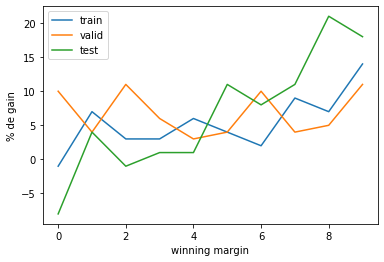

In [135]:
# Seuils de winning margin
liste_thresh = []
for dec in np.arange(0,10,1):
    liste_thresh.append(dec)
liste_thresh    
plt.plot(liste_thresh,gain_train, label = "train")
plt.plot(liste_thresh,gain_valid,label = "valid")
plt.plot(liste_thresh,gain_test,label = "test")
plt.xlabel('winning margin')
plt.ylabel('% de gain')
leg = plt.legend()

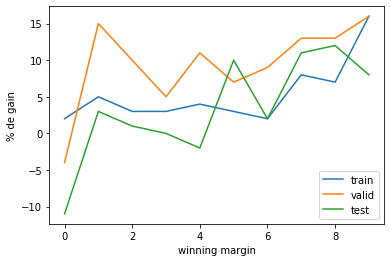

In [130]:
# Seuils de winning margin
liste_thresh = []
for dec in np.arange(0,10,1):
    liste_thresh.append(dec)
liste_thresh    
plt.plot(liste_thresh,gain_train, label = "train")
plt.plot(liste_thresh,gain_valid,label = "valid")
plt.plot(liste_thresh,gain_test,label = "test")
plt.xlabel('winning margin')
plt.ylabel('% de gain')
leg = plt.legend()

In [131]:
pct_good_train = []
for each in liste_gain_train:
    pct_good_train.append(each[1])
    
pct_good_valid = []
for each in liste_gain_valid:
    pct_good_valid.append(each[1])
    
pct_good_test = []
for each in liste_gain_test:
    pct_good_test.append(each[1])

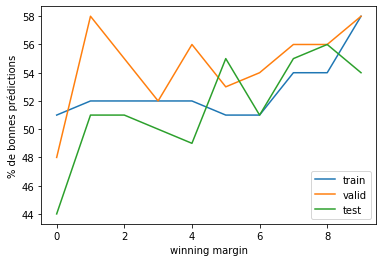

In [132]:
# Seuils de winning margin
liste_thresh = []
for dec in np.arange(0,10,1):
    liste_thresh.append(dec)
    
plt.plot(liste_thresh,pct_good_train, label = "train")
plt.plot(liste_thresh,pct_good_valid,label = "valid")
plt.plot(liste_thresh,pct_good_test,label = "test")
plt.xlabel('winning margin')
plt.ylabel('% de bonnes prédictions')
leg = plt.legend()

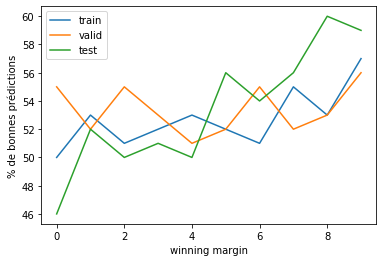

In [138]:
# Seuils de winning margin
liste_thresh = []
for dec in np.arange(0,10,1):
    liste_thresh.append(dec)
    
plt.plot(liste_thresh,pct_good_train, label = "train")
plt.plot(liste_thresh,pct_good_valid,label = "valid")
plt.plot(liste_thresh,pct_good_test,label = "test")
plt.xlabel('winning margin')
plt.ylabel('% de bonnes prédictions')
leg = plt.legend()

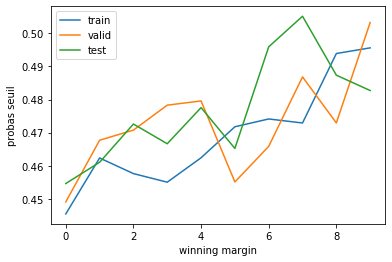

In [133]:
probas_train = []
for each in liste_gain_train:
    probas_train.append(each[0])
    
probas_valid = []
for each in liste_gain_valid:
    probas_valid.append(each[0])
    
probas_test = []
for each in liste_gain_test:
    probas_test.append(each[0])
    
# Seuils de winning margin
liste_thresh = []
for dec in np.arange(0,10,1):
    liste_thresh.append(dec)
    
plt.plot(liste_thresh,probas_train, label = "train")
plt.plot(liste_thresh,probas_valid,label = "valid")
plt.plot(liste_thresh,probas_test,label = "test")
plt.xlabel('winning margin')
plt.ylabel('probas seuil')
leg = plt.legend()

##  Comment on calcule le % de gains obtenus globalement sur chaque dataset ?
sachant que pour le modèle sans winning margin j'ai obtenu:
- train : 33%
- valid : 22%
- test : 25%

### Evaluation du modèle sur le test set margin
- d'abord sur le test set que j'avais construit avec la méthode "winning margin"
- ensuite, avec le test set construit sans la méthode "wining margin"

In [224]:
liste_columns_test =  liste_feat_for_xgboost_modele_1
liste_columns_test.append("id_match")

In [238]:
liste_columns_test

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'id_match']

In [225]:
df_temp = X_test_all_columns[liste_columns_test]
df_temp = df_temp.sort_values(by = "id_match")
Y_test = Y_test.sort_values(by = "id_match")

df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]
predicted_values_test = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
predicted_values_test = np.expand_dims(predicted_values_test, axis=1)
Y_test_without_id_match = Y_test.drop("id_match", axis = 1)

In [226]:
AUC_test_value = roc_auc_score(Y_test_without_id_match.values, predicted_values_test)
print ("AUC sur le test set: ", AUC_test_value)

df_predicted_values_test = pd.DataFrame({'id_match':df_temp["id_match"].values, 'pred': predicted_values_test[:, 0]})

AUC sur le test set:  0.7554500448957953


In [227]:
df_predicted_values_test.head()

,id_match,pred
0,1991-201_13,0.618972
1,1991-201_13,0.377267
2,1991-201_14,0.559953
3,1991-201_14,0.420432
4,1991-201_19,0.567847


In [228]:
Y_test.reset_index(drop = False, inplace = True)
df_predicted_values_test.reset_index(drop = False, inplace = True)
df_predicted_values_test["Y"] = Y_test["Y"]

In [229]:
df_temp_names_players = X_test_all_columns[["id_match","player_name","opponent_name"]]
df_temp_names_players = df_temp_names_players.sort_values(by = "id_match")
df_temp_names_players.reset_index(drop = False, inplace = True)
df_predicted_values_test.reset_index(drop = False, inplace = True)
df_predicted_values_test["player_name"] = df_temp_names_players["player_name"]
df_predicted_values_test["opponent_name"] = df_temp_names_players["opponent_name"]

df_predicted_values_test = df_predicted_values_test.drop(["level_0","index"], axis = 1)
df_predicted_values_test.head(n=20)

,id_match,pred,Y,player_name,opponent_name
0,1991-201_13,0.618972,1,Marcelo Saliola,Tarik Benhabiles
1,1991-201_13,0.377267,0,Tarik Benhabiles,Marcelo Saliola
2,1991-201_14,0.559953,0,Chris Garner,Christer Allgardh
3,1991-201_14,0.420432,1,Christer Allgardh,Chris Garner
4,1991-201_19,0.567847,1,Gabriel Markus,Patrick Baur
5,1991-201_19,0.442596,0,Patrick Baur,Gabriel Markus
6,1991-201_25,0.479592,0,Shuzo Matsuoka,Rodolphe Gilbert
7,1991-201_25,0.563067,1,Rodolphe Gilbert,Shuzo Matsuoka
8,1991-201_26,0.483966,0,Patrick Baur,Diego Perez
9,1991-201_26,0.513814,1,Diego Perez,Patrick Baur


#### Evaluation grâce aux gains en cas de bonnes prédictions ou de mauvaises prédictions:
on utilise "df_pred_test_built_without_win_margin"

In [277]:
def compute_gain(df):
    resultat = []
    precision, recall, thresholds = precision_recall_curve(df[["Y"]], df[["pred"]])
    f1 = 2*((precision*recall)/(precision+recall))

    # On définit le seuil de probabilité : c'est la proba telle que le F1-score soit maximum
    thresh_proba = thresholds[np.where(f1 == max(f1))][0]
    
    print ("THRESHOLD PROBA with MAX F1 :", thresh_proba)

    df['Y_pred'] = df['pred'].map(lambda x: 1 if x > thresh_proba else 0)
    df['gain'] = df.apply(gain_for_each_match, axis = 1)
    
    # % des victoires prédites correctement
    # Et % des gains obtenus en misant 1 euro pour chaque match
    resultat.append(round((len(df[df.gain == 1])/len(df))*100))
    resultat.append(round((df.gain.sum()/len(df))*100))

    return resultat

In [278]:
def gain_for_each_match(df):
    if df['Y'] == df['Y_pred']:
        gain = +1 
    else:
        gain = -1 
    return gain

In [269]:
df_pred_test_built_without_win_margin = pd.read_pickle('df_pred_test_built_without_win_margin.pkl')
Y_test_built_without_win_margin = pd.read_pickle('Y_test_built_without_win_margin.pkl')

In [270]:
list(Y_test_built_without_win_margin)

['Y']

In [254]:
# df_pred_test_built_without_win_margin = df_pred_test_built_without_win_margin.drop(labels= ['pred','Y_pred','gain'],axis = 1)

In [271]:
list(df_pred_test_built_without_win_margin)

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'id_match']

In [272]:
liste_columns_test

['surface_labels_encoding',
 'tourney_level_labels_encoding',
 'player_hand_labels_encoding',
 'opponent_hand_labels_encoding',
 'player_ht',
 'player_age',
 'player_rank',
 'player_rank_points',
 'opponent_ht',
 'opponent_age',
 'opponent_rank',
 'opponent_rank_points',
 'id_match']

In [273]:
df_temp = df_pred_test_built_without_win_margin[liste_columns_test]
df_temp = df_temp.sort_values(by = "id_match")

df_temp_for_prediction = df_temp[[each for each in list(df_temp) if each != "id_match"]]
predicted_values_test = xgb_model.predict_proba(df_temp_for_prediction)[:,1]
predicted_values_test = np.expand_dims(predicted_values_test, axis=1)

In [274]:
df_predicted_values_test = pd.DataFrame({'id_match':df_temp.id_match, 'Y':Y_test_built_without_win_margin.Y,'pred': predicted_values_test[:, 0]})

In [258]:
# df_predicted_values_test = pd.DataFrame({'id_match':df_temp["id_match"].values, 'Y':Y_test_built_without_win_margin.Y_test_built_without_win_margin,'pred': predicted_values_test[:, 0]})

In [276]:
list(df_predicted_values_test)

['id_match', 'Y', 'pred', 'Y_pred']

In [279]:
compute_gain(df_predicted_values_test)

THRESHOLD PROBA with MAX F1 : 0.34551278


[65, 30.0]

VERSUS résultat avec modèle sans winning margin appliqué sur les mêmes données de test:<br>
THRESHOLD PROBA with MAX F1 : 0.3253111<br>
[62, 24.0]

Conclusion: le modèle avec winning margin est meilleur<br>
- la proba seuil pour décider qu'une prédiction est équivalente à une victoire, est supérieure (0.3455 contre 0.3253)
- le % de victoires prédites est meilleur (65% contre 62%)
- le % de gains obtenus est meilleur (30% contre 24%)

EST-CE QUE CELA VEUT DIRE QU'EN PARIANT SANS TENIR COMPTE DES COTES DES JOUEURS pour un match donné<br>
on pourrait gagner de l'argent en pariant pour 100 matchs ? <br>
et le modèle donnerait 30 euros de gains pour 1 euro parié par match